In [179]:
!pip install pandas > /dev/null
!pip install numpy > /dev/null
!pip install matplotlib > /dev/null
!pip install scipy > /dev/null
!pip install numba > /dev/null


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [283]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

### Q1: Simulating ODE

#### Euler's Explicit

In [19]:
f_n_exp = [0]
t = [0.9999999]
n = 100
h = 1/n


def F(t, f):
    return f / (1-t) + 1


while (t[-1] > 0):
    f_n_exp.append(f_n_exp[-1] - h * F(t[-1], f_n_exp[-1]))
    t.append(t[-1] - h)



#### Euler's Implicit

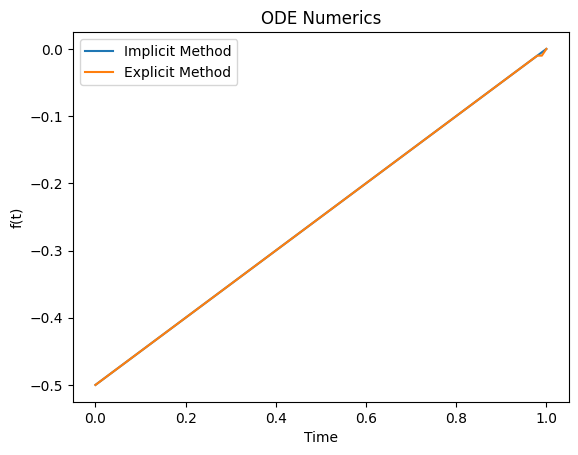

In [21]:
f_n_imp = [0]
t = [1]
n = 100
h = 1/n

while (t[-1] > 0):
    t.append(t[-1] - h)
    num = (f_n_imp[-1] - h) * (1 - t[-1])
    den = 1 - t[-1] + h
    f_n_imp.append(num / den)

plt.plot(t, f_n_imp, label='Implicit Method')
plt.plot(t, f_n_exp, label='Explicit Method')
plt.legend()
plt.title("ODE Numerics")
plt.xlabel("Time")
plt.ylabel("f(t)")
plt.show()


#### Modifying the initial condition

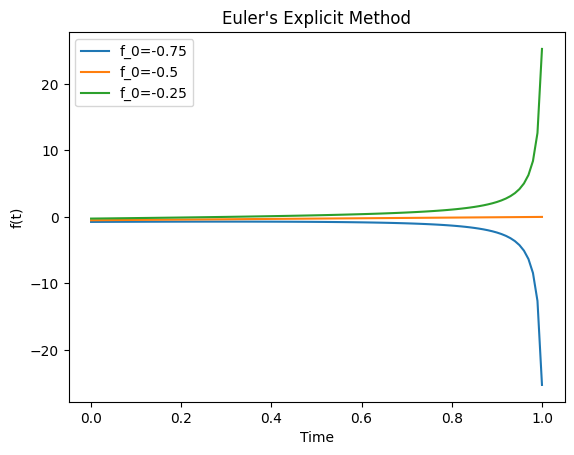

In [37]:
f_initial = [-3/4, -1/2, -1/4]
n = 100
h = 1/n


def F(t, f):
    return f / (1-t) + 1

for f_0 in f_initial:
    f_n_exp = [f_0]
    t = [0]
    while (t[-1] < 1):
        f_n_exp.append(f_n_exp[-1] + h * F(t[-1], f_n_exp[-1]))
        t.append(t[-1] + h)
    plt.plot(t, f_n_exp, label=f'f_0={f_0}')
plt.title("Euler's Explicit Method")
plt.xlabel("Time")
plt.ylabel("f(t)")
plt.legend()
plt.show()

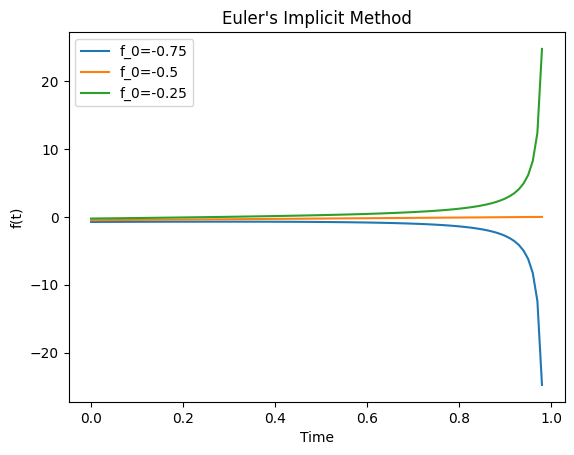

In [ ]:
f_initial = [-3/4, -1/2, -1/4]
n = 100
h = 1/n

for f_0 in f_initial:
    f_n_imp = [f_0]
    t = [0]
    while (t[-1] + 2*h < 1): # bound domain for graphing
        t.append(t[-1] + h)
        num = (f_n_imp[-1] + h) * (1 - t[-1])
        den = 1 - t[-1] - h
        f_n_imp.append(num / den)
    plt.plot(t, f_n_imp, label=f'f_0={f_0}')

plt.title("Euler's Implicit Method")
plt.xlabel("Time")
plt.ylabel("f(t)")
plt.legend()
plt.show()


### Pricing European Put Options

In [172]:
from scipy.linalg import lu
from scipy.linalg import solve_triangular
from scipy.stats import norm
from scipy.linalg import solve_banded

In [186]:
k = 1
sig = 0.3
T = 0.5
r = 0


s_initial = [1.5]#[0.5, 1, 1.5]
m_initial = np.arange(100, 6500, 100)
x_L = 0
x_H = 5 # changing this decreases speed of convergence but runs faster
# 2 is smallest with enough accuracy
def u_T(x): # starting from t=T -> t=0
    return np.maximum(k-x, 0)
def u_xL(t):
    return k
def u_xH(t):
    return 0
def V_0(s_0): # black scholes
    d1 = (np.log(s_0 / k) + (r + 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    d2 = d1 - sig * np.sqrt(T)
    put_price = k * np.exp(-r * T) * norm.cdf(-d2) - s_0 * norm.cdf(-d1)
    return put_price

u_mn

for s_0 in s_initial:
    for m_max in m_initial:
        dt = T/m_max
        dx = dt / 0.5
        x_n = np.arange(x_L, x_H + dx, dx)
        n = len(x_n)
        I = np.diag(np.ones(n))
        alpha = dt / (dx ** 2)
        u_mn = np.zeros((m_max, n))
        u_mn[m_max - 1] = u_T(x_n)
        lambda_ = (sig ** 2) * np.square(x_n) * alpha
        lambda_L = (sig ** 2) * (x_L ** 2) * alpha
        lambda_H = (sig ** 2) * (x_H ** 2) * alpha
        A = np.diag(1/2 * lambda_[1:n], k=-1) + np.diag((1 - lambda_)) + np.diag(1/2 * lambda_[0:n-1], k=1)
        B = np.diag(-1/2 * lambda_[1:n], k=-1) + np.diag((1 + lambda_)) + np.diag(-1/2 * lambda_[0:n-1], k=1)
        L, U = lu(1/2 * (I + B), permute_l=True)

        for m in range(m_max - 2, -1, -1): 
            v = np.zeros(n)
            v[0] = -1/4 * lambda_L * (u_xL((m) * dt) + u_xL((m+1) * dt))
            v[n-1] = -1/4 * lambda_H * (u_xH(m * dt) + u_xH((m+1) * dt))
            lhs = (1/2 * (I + A)) @ u_mn[m+1] + v
            y = solve_triangular(L, lhs, lower=True)
            u_mn[m] = solve_triangular(U, y)
        idx = int((s_0 - x_L) / dx)
        print(f'European Put priced with Crank Nicholsan for s_0={s_0}, m={m_max}, U_mn={u_mn[0][idx]}')
        print(f'Black Scholes Price for s_0={s_0}, m={m_max}, U(t, x)={V_0(s_0)}\n')



European Put priced with Crank Nicholsan for s_0=1.5, m=100, U_mn=0.0026941364352255433
Black Scholes Price for s_0=1.5, m=100, U(t, x)=0.0027760395273241922

European Put priced with Crank Nicholsan for s_0=1.5, m=200, U_mn=0.0027348241431744635
Black Scholes Price for s_0=1.5, m=200, U(t, x)=0.0027760395273241922

European Put priced with Crank Nicholsan for s_0=1.5, m=300, U_mn=0.0028216405728173463
Black Scholes Price for s_0=1.5, m=300, U(t, x)=0.0027760395273241922

European Put priced with Crank Nicholsan for s_0=1.5, m=400, U_mn=0.002755367537783586
Black Scholes Price for s_0=1.5, m=400, U(t, x)=0.0027760395273241922

European Put priced with Crank Nicholsan for s_0=1.5, m=500, U_mn=0.0027594917523248892
Black Scholes Price for s_0=1.5, m=500, U(t, x)=0.0027760395273241922

European Put priced with Crank Nicholsan for s_0=1.5, m=600, U_mn=0.002798714964569164
Black Scholes Price for s_0=1.5, m=600, U(t, x)=0.0027760395273241922

European Put priced with Crank Nicholsan for s_0

KeyboardInterrupt: 

Text(0, 0.5, 'PDE Price / Closed Form Price')

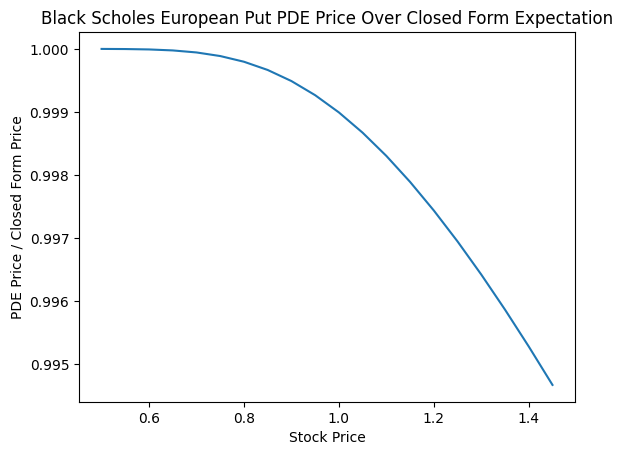

In [ ]:
k = 1
sig = 0.3
T = 0.5
r = 0


s_initial = [1.5]#[0.5, 1, 1.5]
m_initial = np.arange(100, 6500, 100)
x_L = 0
x_H = 5 # changing this decreases speed of convergence but runs faster
# 2 is smallest with enough accuracy
def u_T(x): # starting from t=T -> t=0
    return np.maximum(k-x, 0)
def u_xL(t):
    return k
def u_xH(t):
    return 0
def V_0(s_0): # black scholes
    d1 = (np.log(s_0 / k) + (r + 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    d2 = d1 - sig * np.sqrt(T)
    put_price = k * np.exp(-r * T) * norm.cdf(-d2) - s_0 * norm.cdf(-d1)
    return put_price

u_mn

for s_0 in s_initial:
    for m_max in m_initial:
        dt = T/m_max
        dx = dt / 0.5
        x_n = np.arange(x_L, x_H + dx, dx)
        n = len(x_n)
        I = np.diag(np.ones(n))
        alpha = dt / (dx ** 2)
        u_mn = np.zeros((m_max, n))
        u_mn[m_max - 1] = u_T(x_n)
        lambda_ = (sig ** 2) * np.square(x_n) * alpha
        lambda_L = (sig ** 2) * (x_L ** 2) * alpha
        lambda_H = (sig ** 2) * (x_H ** 2) * alpha
        A = np.diag(1/2 * lambda_[1:n], k=-1) + np.diag((1 - lambda_)) + np.diag(1/2 * lambda_[0:n-1], k=1)
        B = np.diag(-1/2 * lambda_[1:n], k=-1) + np.diag((1 + lambda_)) + np.diag(-1/2 * lambda_[0:n-1], k=1)
        L, U = lu(1/2 * (I + B), permute_l=True)

        for m in range(m_max - 2, -1, -1): 
            v = np.zeros(n)
            v[0] = -1/4 * lambda_L * (u_xL((m) * dt) + u_xL((m+1) * dt))
            v[n-1] = -1/4 * lambda_H * (u_xH(m * dt) + u_xH((m+1) * dt))
            lhs = (1/2 * (I + A)) @ u_mn[m+1] + v
            y = solve_triangular(L, lhs, lower=True)
            u_mn[m] = solve_triangular(U, y)
        idx = int((s_0 - x_L) / dx)
        print(f'European Put priced with Crank Nicholsan for s_0={s_0}, m={m_max}, U_mn={u_mn[0][idx]}')
        print(f'Black Scholes Price for s_0={s_0}, m={m_max}, U(t, x)={V_0(s_0)}\n')



### Richardson Exterpolation

In [281]:
k = 1
sig = 0.3
T = 0.5
r = 0
s_0 = 0.5
m_initial = [100, 200, 400, 800, 1600]
prices = {}
x_L = 0
x_H = 5 # changing this decreases speed of convergence but runs faster
# 2 is smallest with enough accuracy
def u_T(x): # starting from t=T -> t=0
    return np.maximum(k-x, 0)
def u_xL(t):
    return k
def u_xH(t):
    return 0
def V_0(s_0): # black scholes
    d1 = (np.log(s_0 / k) + (r + 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    d2 = d1 - sig * np.sqrt(T)
    put_price = k * np.exp(-r * T) * norm.cdf(-d2) - s_0 * norm.cdf(-d1)
    return put_price

u_mn
for s_0 in s_initial:
    O = []
    for m_max in m_initial:
        dt = T/m_max
        dx = dt / 0.5
        x_n = np.arange(x_L, x_H + dx, dx)
        n = len(x_n)
        I = np.diag(np.ones(n))
        alpha = dt / (dx ** 2)
        u_mn = np.zeros((m_max, n))
        u_mn[m_max - 1] = u_T(x_n)
        lambda_ = (sig ** 2) * np.square(x_n) * alpha
        lambda_L = (sig ** 2) * (x_L ** 2) * alpha
        lambda_H = (sig ** 2) * (x_H ** 2) * alpha
        A = np.diag(1/2 * lambda_[1:n], k=-1) + np.diag((1 - lambda_)) + np.diag(1/2 * lambda_[0:n-1], k=1)
        B = np.diag(-1/2 * lambda_[1:n], k=-1) + np.diag((1 + lambda_)) + np.diag(-1/2 * lambda_[0:n-1], k=1)
        L, U = lu(1/2 * (I + B), permute_l=True)
        for m in range(m_max - 2, -1, -1): 
            v = np.zeros(n)
            v[0] = -1/4 * lambda_L * (u_xL((m) * dt) + u_xL((m+1) * dt))
            v[n-1] = -1/4 * lambda_H * (u_xH(m * dt) + u_xH((m+1) * dt))
            lhs = (1/2 * (I + A)) @ u_mn[m+1] + v
            y = solve_triangular(L, lhs, lower=True)
            u_mn[m] = solve_triangular(U, y)
        idx = int((s_0 - x_L) / dx)
        O.append(u_mn[0][idx])
    prices[s_0] = O
    # order = np.log((O[0] - O[1]) / (O[1] - O[2])) / np.log(2)
    # print(f'Crank Nicholsan Order={order}\n')



In [286]:
prices[0.5]

[np.float64(0.5000205006355087),
 np.float64(0.5000208795865746),
 np.float64(0.5000211512846954),
 np.float64(0.5000213083321399),
 np.float64(0.5000213922326042)]

In [284]:
for s_0 in prices:
    price_list = prices[s_0]
    for i in range(2, len(price_list)):
        k = math.log2((price_list[i-2] - price_list[i-1]) / (price_list[i-1] - price_list[i]))
        print(f'order={k}')

order=0.4800069774091952
order=0.7908041197194878
order=0.9044497668558371
order=1.0583397929099452
order=1.0299251711358246
order=1.0151623845844384
order=0.985918418111359
order=0.9932143483674717
order=0.9966687747691436


In [294]:
for s_0 in prices:
    price_list = prices[s_0]
    print(f's_0={s_0}')
    for i in range(1, len(price_list)):
        richard = (2 * price_list[i] - price_list[i-1]) / (2 - 1)
        print(f'richardson estimate:{richard}')
    print('\n')

s_0=0.5
richardson estimate:0.5000212585376405
richardson estimate:0.5000214229828162
richardson estimate:0.5000214653795844
richardson estimate:0.5000214761330686


s_0=1
richardson estimate:0.08448207998986859
richardson estimate:0.08447302698311238
richardson estimate:0.08447077519458054
richardson estimate:0.0844702135826406


s_0=1.5
richardson estimate:0.0027755118511233836
richardson estimate:0.002775910932392709
richardson estimate:0.002776007784923131
richardson estimate:0.002776031641924282




### Delta Approximation

delta[0.5]=-0.9989250921472403

delta[1.0]=-0.4652009342975033

delta[1.5]=-0.022706223289160193



Text(0, 0.5, 'Delta')

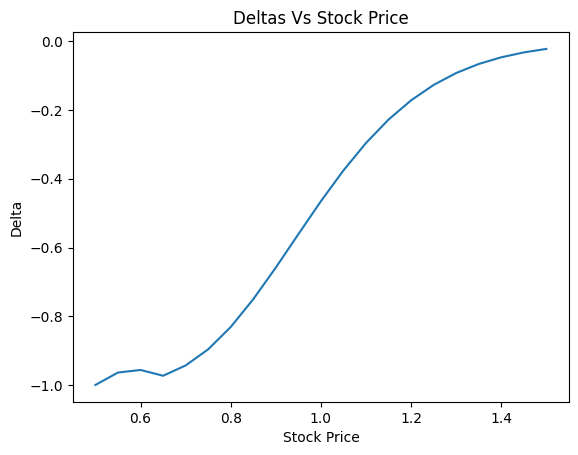

In [261]:
k = 1
sig = 0.3
T = 0.5
r = 0


s_initial = np.arange(0.45, 1.6, 0.05)
x_L = 0
x_H = 5 # changing this decreases speed of convergence but runs faster
# 2 is smallest with enough accuracy
def u_T(x): # starting from t=T -> t=0
    return np.maximum(k-x, 0)
def u_xL(t):
    return k
def u_xH(t):
    return 0
def V_0(s_0): # black scholes
    d1 = (np.log(s_0 / k) + (r + 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    d2 = d1 - sig * np.sqrt(T)
    put_price = k * np.exp(-r * T) * norm.cdf(-d2) - s_0 * norm.cdf(-d1)
    return put_price

u_mn
prev = 0
prev_prev = 0

deltas = []

for s_0 in s_initial:
    m_max = 300
    dt = T/m_max
    dx = dt / 0.5
    x_n = np.arange(x_L, x_H + dx, dx)
    n = len(x_n)
    I = np.diag(np.ones(n))
    alpha = dt / (dx ** 2)
    u_mn = np.zeros((m_max, n))
    u_mn[m_max - 1] = u_T(x_n)
    lambda_ = (sig ** 2) * np.square(x_n) * alpha
    lambda_L = (sig ** 2) * (x_L ** 2) * alpha
    lambda_H = (sig ** 2) * (x_H ** 2) * alpha
    A = np.diag(1/2 * lambda_[1:n], k=-1) + np.diag((1 - lambda_)) + np.diag(1/2 * lambda_[0:n-1], k=1)
    B = np.diag(-1/2 * lambda_[1:n], k=-1) + np.diag((1 + lambda_)) + np.diag(-1/2 * lambda_[0:n-1], k=1)
    L, U = lu(1/2 * (I + B), permute_l=True)

    for m in range(m_max - 2, -1, -1): 
        v = np.zeros(n)
        v[0] = -1/4 * lambda_L * (u_xL((m) * dt) + u_xL((m+1) * dt))
        v[n-1] = -1/4 * lambda_H * (u_xH(m * dt) + u_xH((m+1) * dt))
        lhs = (1/2 * (I + A)) @ u_mn[m+1] + v
        y = solve_triangular(L, lhs, lower=True)
        u_mn[m] = solve_triangular(U, y)
    idx = int((s_0 - x_L) / dx)
    if s_0 == .45:
        prev_prev = u_mn[0][idx]
        continue
    if s_0 == .5:
        prev = u_mn[0][idx]
        continue
    delta = (u_mn[0][idx] - prev_prev) / (2 * 0.05)
    deltas.append(delta)
    prev_prev = prev
    prev = u_mn[0][idx]
    if round(s_0, 2) == 0.55 or round(s_0, 2) == 1.05 or round(s_0, 2) == 1.55:
        print(f'delta[{round(s_0, 2) - 0.05}]={delta}\n')

    
plt.plot(s_initial[1:-1], deltas)
plt.title('Deltas Vs Stock Price')
plt.xlabel('Stock Price')
plt.ylabel('Delta')



### Broadie and Glasserman's Delta

In [262]:
import numpy as np

k = 1
sig = 0.3
T = 0.5
r = 0

s_initial = [0.5, 1, 1.5]
n = 1_000_000

for s_0 in s_initial:
    samples = []
    for _ in range(n):
        B_T = np.random.normal(0, np.sqrt(T)) 
        S_T = s_0 * np.exp(sig * B_T - 0.5 * sig**2 * T)
        if S_T < k:
            samples.append(-S_T / s_0)
        else:
            samples.append(0)
    samples = np.array(samples)
    mean = samples.mean()
    std_err = samples.std(ddof=1) / np.sqrt(n)
    ci_low = mean - 1.96 * std_err
    ci_high = mean + 1.96 * std_err
    print(f"s_0={s_0}: Delta ≈ {mean:.5f}, 95% CI = [{ci_low:.5f}, {ci_high:.5f}]")

s_0=0.5: Delta ≈ -0.99914, 95% CI = [-0.99956, -0.99872]
s_0=1: Delta ≈ -0.45801, 95% CI = [-0.45885, -0.45717]
s_0=1.5: Delta ≈ -0.02167, 95% CI = [-0.02190, -0.02145]


### Broadie and Glasserman's Likelihood 

In [263]:
import numpy as np

k = 1
sig = 0.3
T = 0.5
r = 0

s_initial = [0.5, 1, 1.5]
n = 10_000_000

def F(x, s_0):
    return (np.log(x / s_0) + 1/2 * (sig ** 2) * T) / (s_0 * (sig ** 2) * T)

for s_0 in s_initial:
    B_T = np.random.normal(0, np.sqrt(T), n)
    s_T = s_0 * np.exp(sig * B_T - 1/2 * (sig ** 2) * T)
    samples = np.maximum(k - s_T, 0) * F(s_T, s_0)
    mean = samples.mean()
    std_err = samples.std(ddof=1) / np.sqrt(n)
    ci_low = mean - 1.96 * std_err
    ci_high = mean + 1.96 * std_err
    print(f"s_0={s_0}: Delta ≈ {mean:.5f}, 95% CI = [{ci_low:.5f}, {ci_high:.5f}]")

s_0=0.5: Delta ≈ -1.00008, 95% CI = [-1.00302, -0.99715]
s_0=1: Delta ≈ -0.45770, 95% CI = [-0.45828, -0.45712]
s_0=1.5: Delta ≈ -0.02189, 95% CI = [-0.02200, -0.02179]
